In [1]:
import pandas as pd
import json
import os
import matplotlib.pyplot as plt
from langchain.vectorstores import Chroma
import yaml
from dill import load

In [2]:
def copy_to_temp_folder(source_folder:str):
    # create a temporary folder
    temp_folder = tempfile.mkdtemp()

    # copy files to temporary folder
    for item in os.listdir(source_folder):
        s = os.path.join(source_folder, item)
        d = os.path.join(temp_folder, item)
        if os.path.isdir(s):
            shutil.copytree(s, d)
        else:
            shutil.copy2(s, d)

    return temp_folder

In [3]:
# Specify the path to your YAML file
file_path_yaml = "./dvc.yaml"

# Open the YAML file and load its contents into a Python object
with open(file_path_yaml, 'r') as f:
    dvc_parameters = yaml.safe_load(f)

args = dvc_parameters['stages']['eval_retrieval_question_gen']['cmd'].split()

vector_database_filename = args[2]

In [4]:
# load embedder
with open(args[3], 'rb') as f:
    embedder = load(f)

KeyError: 'NoneType'

In [36]:
temp = copy_to_temp_folder(vector_database_filename)
vectorstore = Chroma(persist_directory=temp, embedding_function=embedder)


'data/processed/chroma'

# Einführung und Setup
Dieses Notebook dokumentiert unsere Evaluation der Qualität des retrieval Prozesses. Sie basiert auf Resultaten der DVC Stage `eval_retrieval_metrics.py`, welche den reciprocal rank für Dokumente, die von einem ausgesuchten Embedder (hier `distiluse-base-multilingual-cased-v1`) als relevant eingestuft wurden, bestimmt und daraus den Mean reciprocal rank berechnet. Die Resultate dieser Stage werden im Ordner `data/processed` abgelegt und können mittels `dvc pull` bezogen werden, sofern die benötigten Berechtigungen vorhanden sind.   

# Reciprocal rank und mean reciprocal rank  
 Der reciprocal rank gibt an, an welcher Stelle das korrekte Dokument durch den Embedder empfohlen worden ist. In diesem Fall steht das korrekte Dokument für jenes, welches genutzt worden ist, um mit dem llm `LeoLM/leo-mistral-hessianai-7b-chat` die im hier verwendeten Datensatz vorhandene Frage zu generieren. Wenn das Modell stets die korrekte Rückmeldung liefert, würde der Rank für jedes Dokument 1 sein.  
 
Aus einer Liste solcher Rankings kann dann eine zusammenfassende Metrik, der mean reciprocal rank, berechnet werden. Die Formel dafür lautet wie folgt:  
$$
 \text{MRR} = \sum_{i=1}^{|Q|}\frac{1}{\text{rank}_i}
$$
wobei:
- $|Q|$: die Anzahl gestellter Fragen
- $\text{rank}$: der reciprocal rank

Dieser Durchschnittswert entspricht dem harmonischen Mittel der Ranks. 

In [20]:
# read ranks data
ranks_file_path = "./data/processed/eval_retrieval_ranks.csv"

if os.path.isfile(ranks_file_path):
    df_ranks = pd.read_csv(ranks_file_path)
    print(df_ranks.head())
else:
    print("Ranks file is not available, please provide it using dvc")

   Unnamed: 0  \
0           0   
1           1   
2           2   
3           3   
4           4   

                                                                                                                question  \
0                    Was ist das Ausbildungskonzept für den Studiengang Data Science an der Hochschule für Technik FHNW?   
1                                    Was ist das Ziel des Ausbildungskonzepts laut dem Inhaltsverzeichnis des Dokuments?   
2                                                                 Was wird auf den Seiten 3 bis 22 des Inputs behandelt?   
3                                       Welches Ziel hat die Bachelor-Ausbildung an der Hochschule für Technik der FHNW?   
4  Was ist das Ziel des Studiengangs Data Science und wie bereiten sie die Studierenden auf die heutige Arbeitswelt vor?   

   rank  
0    11  
1    15  
2   146  
3     1  
4   211  


In [9]:
# read mrr 
mrr_file_path = "./data/processed/eval_retrieval_metrics.json"

if os.path.isfile(mrr_file_path):
    with open(mrr_file_path, 'r') as f:
      mrr = json.load(f)
    print(mrr)
else:
    print("Metrics file is not available, please provide it using dvc")

{'mrr': 0.5115116621454743}


# MRR
In unserem Test haben wir einen MRR von rund 0.512 erreicht. Da es sich aber um einen Mittelwert handelt, überprüfen wir nachfolgend die Verteilung der Rankings und allfällige Ausreisser.

In [21]:
# clean up df_ranks
df_ranks = df_ranks.rename(columns={df_ranks.columns[0]: 'id'})

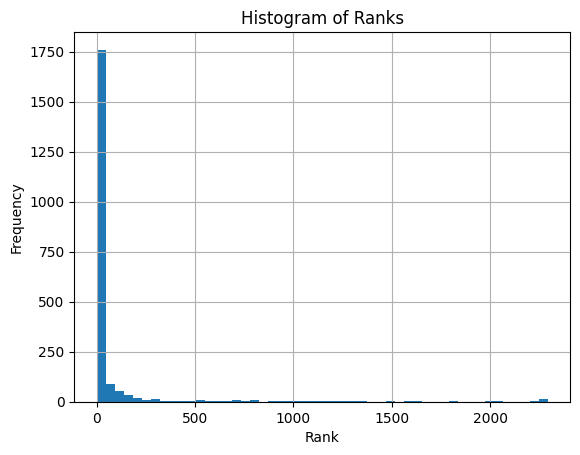

In [11]:
# Plot histogram
df_ranks['rank'].hist(bins=50)

# Add labels and title
plt.xlabel('Rank')
plt.ylabel('Frequency')
plt.title('Histogram of Ranks')
# Show the plot
plt.show()

In diesem Plot ist die Verteilung der aufgezeichneten reciprocal ranks zu sehen. Auffällig ist, dass sehr viele sich im Bereich von 1 befinden und ein paar wenige Observationen einen Rank von > 2000 erreicht haben. Nachfolgend wird die Verteilung der Observationen genauer untersucht. 

In [12]:
df_ranks['rank'].describe()

count    2123.000000
mean       91.640603
std       316.300130
min         1.000000
25%         1.000000
50%         2.000000
75%        20.000000
max      2294.000000
Name: rank, dtype: float64

75% der aufgezeichneten Rankings weisen einen Wert von 20 oder weniger auf, wobei der grösste erreichte Wert bei 2294 liegt. Für einen im Verhältnis kleinen Anteil der Fragen mussten also deutlich mehr Dokumente vorgeschlagen werden, bis das richtige gefunden wurde. Da es sich beim MRR um ein harmonisches Mittel handelt, bewegen diese wenigen Ausreisser den MRR mehr gegen 0. Trotz einem relativ schwachen MRR von 0.512 werden sehr viele Dokumente im ersten Versuch korrekt identifiziert. Bei welchen Dokumenten das nicht passiert, wird nachfolgend genauer untersucht.      

In [13]:
pd.set_option('display.max_colwidth', None)
top_10_rows = df_ranks.nlargest(10, 'rank')

# Print the top 10 rows with the highest ranks
print(top_10_rows)

                                                                                                                question  \
1188                                        Welche Auswirkungen hat die Abholzung auf die Tierwelt und ihre Lebensräume?   
1187                                        Welche Auswirkungen hat die Abholzung auf die Tierwelt und ihre Lebensräume?   
290   Welche Herausforderungen und Chancen ergeben sich durch die schnelle Verbreitung von Technologie in unserem Leben?   
1811                                      Wie viele ganze Zahlen gibt es in der Liste $ 2000, 2001, 2002, \ldots, 4000$?   
1475                               Wie viele positive ganze Zahlen kleiner als 100 haben eine gerade Anzahl von Teilern?   
1474                               Wie viele positive ganze Zahlen kleiner als 100 haben eine gerade Anzahl von Teilern?   
1345                               Wie viele positive ganze Zahlen kleiner als 100 haben eine gerade Anzahl von Teilern?   
1200    

In [14]:
# Assuming df_ranks is your DataFrame and 'ranks' is the column you're interested in
pd.set_option('display.max_colwidth', None)
top_10_rows = df_ranks.nsmallest(10, 'rank')

# Print the top 10 rows with the highest ranks
print(top_10_rows)

                                                                                                                                            question  \
3                                                                   Welches Ziel hat die Bachelor-Ausbildung an der Hochschule für Technik der FHNW?   
20                                                    Wie viele Studierende haben Prüfungen von Modulen im Gegenwert von 60 Credits nicht bestanden?   
26                                  Wie viele Credits muss ein Student im Studiengang Data Science erwerben, um den Bachelor-Abschluss zu erreichen?   
36                                                                                Was sind die Rechte und Pflichten der Studierenden gemäß der FHNW?   
37                                                                Was ist das Portfoliomodul für das 2D-BSc-Data-Science-Programm im Herbstsemester?   
39                                                                        Welche Lernerg